In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
import pickle

# Paths to the prepped data files
base_path = './daily_data/'  # Adjusted base path to where our files are now
X_train_path = base_path + 'X_train.csv'
X_test_path = base_path + 'X_test.csv'
y_train_path = base_path + 'y_train.csv'
y_test_path = base_path + 'y_test.csv'

# Loading the datasets
X_train = pd.read_csv(X_train_path)
X_test = pd.read_csv(X_test_path)
y_train = pd.read_csv(y_train_path)
y_test = pd.read_csv(y_test_path)

# Convert columns to numeric, coercing errors to NaN
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Initialize the scaler for the features
scaler_X = MinMaxScaler()

# Scale 'X' features
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Initialize a separate scaler for the target variable
scaler_y = MinMaxScaler()

# Scale 'y' (the target variable)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['date' 'classification']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['date' 'classification']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


## Function to save models for later

In [2]:
# DataFrame to store results
results_df = pd.DataFrame(columns=['Model', 'RMSE'])

In [3]:
from datetime import datetime
import os

# DataFrame to store results
results_df = pd.DataFrame(columns=['Model', 'RMSE'])

def save_model_and_scalers(model, scaler_X, scaler_y, model_type):
    """
    Save the Keras model and scalers with a timestamp and type in a directory using pickle.
    
    Parameters:
    - model: The Keras model to save.
    - scaler_X: The scaler used for the X data.
    - scaler_y: The scaler used for the y data.
    - model_type: A string representing the type of the model (e.g., "RNN", "LSTM").
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = f"saved_models/{model_type}"  # Create a directory with the model name
    os.makedirs(save_dir, exist_ok=True)
    
    # Save model
    model.save(f"{save_dir}/{model_type}_{timestamp}.h5")
    
    # Save scalers
    with open(f"{save_dir}/scaler_X_{timestamp}.pkl", 'wb') as f:
        pickle.dump(scaler_X, f)
    with open(f"{save_dir}/scaler_y_{timestamp}.pkl", 'wb') as f:
        pickle.dump(scaler_y, f)


## SimpleRNN

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam

# Reshape the input data to 3D as required by RNN (samples, time steps, features)
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Defining the model
model = Sequential([
    SimpleRNN(50, input_shape=(1, X_train_scaled.shape[1])),  # 50 RNN units
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(), loss='mse')

# Summary of the model architecture
model.summary()

# Train the model
history = model.fit(X_train_reshaped, y_train_scaled, epochs=3, validation_split=0.2)

# Evaluate the model on the test data
test_loss = model.evaluate(X_test_reshaped, y_test_scaled)

# Calculate RMSE and MAPE
y_pred_scaled = model.predict(X_test_reshaped)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
rmse = sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test.values - y_pred) / y_test.values)) * 100

# Save the model and scalers
save_model_and_scalers(model, scaler_X, scaler_y, "SimpleRNN")

# Append results to DataFrame
results_df = pd.concat([results_df, pd.DataFrame({'Model': ['SimpleRNN'], 'RMSE': [rmse], 'MAPE': [mape]})])

print(f"Test Loss: {test_loss}, RMSE: {rmse}, MAPE: {mape}")


/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         4,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,401 (17.19 KB)

 Trainable params: 4,401 (17.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0498 - val_loss: 0.0246
Epoch 2/3
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 0.0038 - val_loss: 0.0075
Epoch 3/3
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 0.0020 - val_loss: 0.0051
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - loss: 0.0089
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Test Loss: 0.0064996094442903996, RMSE: 5376.405362365021, MAPE: 19.692221923598986


/var/folders/jt/f0dtwp_x2w1fvk06tzwm2p200000gn/T/ipykernel_21694/771889377.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'Model': ['SimpleRNN'], 'RMSE': [rmse], 'MAPE': [mape]})])


# LSTM Implementation

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Defining the model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(), loss='mse')

# Train the model
history = model.fit(X_train_reshaped, y_train_scaled, epochs=5, validation_split=0.2)

# Evaluate the model
test_loss = model.evaluate(X_test_reshaped, y_test_scaled)

# Calculate RMSE and MAPE
y_pred_scaled = model.predict(X_test_reshaped)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
rmse = sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test.values - y_pred) / y_test.values)) * 100

# Save the model and scalers
save_model_and_scalers(model, scaler_X, scaler_y, "LSTM")

# Append results to DataFrame
results_df = pd.concat([results_df, pd.DataFrame({'Model': ['LSTM'], 'RMSE': [rmse], 'MAPE': [mape]})])

print(f"Test Loss: {test_loss}, RMSE: {rmse}, MAPE: {mape}")


Epoch 1/5


/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0107 - val_loss: 0.0173
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 0.0021 - val_loss: 0.0132
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 0.0016 - val_loss: 0.0123
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 0.0011 - val_loss: 0.0134
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 0.0012 - val_loss: 0.0153
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step - loss: 0.0196
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Test Loss: 0.01280143391340971, RMSE: 7692.803220685105, MAPE: 31.045402616057572


# GRU Implementation

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Defining the model
model = Sequential([
    GRU(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.2),
    GRU(50, return_sequences=False),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(), loss='mse')

# Train the model
history = model.fit(X_train_reshaped, y_train_scaled, epochs=5, validation_split=0.2)

# Evaluate the model
test_loss = model.evaluate(X_test_reshaped, y_test_scaled)

# Calculate RMSE and MAPE
y_pred_scaled = model.predict(X_test_reshaped)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
rmse = sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test.values - y_pred) / y_test.values)) * 100

# Save the model and scalers
save_model_and_scalers(model, scaler_X, scaler_y, "GRU")

# Append results to DataFrame
results_df = pd.concat([results_df, pd.DataFrame({'Model': ['GRU'], 'RMSE': [rmse], 'MAPE': [mape]})])

print(f"Test Loss: {test_loss}, RMSE: {rmse}, MAPE: {mape}")


Epoch 1/5


/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0115 - val_loss: 0.0300
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 0.0025 - val_loss: 0.0127
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 0.0018 - val_loss: 0.0128
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 0.0015 - val_loss: 0.0090
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 0.0011 - val_loss: 0.0082
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step - loss: 0.0356
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Test Loss: 0.029018405824899673, RMSE: 11582.438217473986, MAPE: 47.73608321139318


**Recommendation:**  
Given the observed performances, the LSTM model appears to be more suitable for our dataset and task. It generalizes better to unseen data, as evidenced by the lower test loss. Pursuing the LSTM model in more detail could involve:

- **Hyperparameter Tuning:** Experiment with different numbers of units in the LSTM layers, learning rates, and batch sizes.
- **Model Complexity:** Try adding more LSTM layers or adjusting the dropout rates to see if the model's generalization capability can be improved further.
- **Regularization Techniques:** Beyond dropout, consider trying other regularization techniques like L1/L2 regularization on the LSTM layers to control overfitting.
- **Early Stopping:** Implement early stopping during training to stop the training process when the validation loss stops decreasing, helping prevent overfitting.


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Data reshaping for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Model definition
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer=Adam(), loss='mse')

# Model summary
model.summary()

# Train the model
history = model.fit(X_train_reshaped, y_train_scaled, epochs=10, validation_split=0.2)

# Evaluate the model
test_loss = model.evaluate(X_test_reshaped, y_test_scaled)

# Calculate RMSE and MAPE
y_pred_scaled = model.predict(X_test_reshaped)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
rmse = sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test.values - y_pred) / y_test.values)) * 100

# Save the model and scalers
save_model_and_scalers(model, scaler_X, scaler_y, "Sequential LSTM")

# Append results to DataFrame
results_df = pd.concat([results_df, pd.DataFrame({'Model': ['Sequential LSTM'], 'RMSE': [rmse], 'MAPE': [mape]})])

print(f"Test Loss: {test_loss}, RMSE: {rmse}, MAPE: {mape}")


/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 1, 50)          │        17,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,201 (157.04 KB)

 Trainable params: 40,201 (157.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0161 - val_loss: 0.0350
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 0.0018 - val_loss: 0.0136
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 0.0019 - val_loss: 0.0137
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 0.0013 - val_loss: 0.0099
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 0.0011 - val_loss: 0.0104
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 9.0753e-04 - val_loss: 0.0069
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 6.5325e-04 - val_loss: 0.0065
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 8.4827e-04 - val_loss: 0.0092
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.7449e-04 - val_loss: 0.0032
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 5.2175e-04 - val_loss: 0.0041
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step - loss: 0.0057
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Test Loss: 0.003720278851687908, RMSE: 4149.896272748791, MAPE: 16.583051770114345


## Adding TimeseriesGenerator

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

n_input = 168  # The number of time steps to look back for predictions
n_features = X_train_scaled.shape[1]  # The number of features in the dataset

# Create the TimeseriesGenerator for training and validation sets
train_generator = TimeseriesGenerator(X_train_scaled, y_train_scaled, length=n_input, batch_size=64)
validation_generator = TimeseriesGenerator(X_test_scaled, y_test_scaled, length=n_input, batch_size=64)

# Define the LSTM model
model = Sequential([
    LSTM(100, activation='relu', input_shape=(n_input, n_features)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(train_generator, epochs=10, validation_data=validation_generator)

# Save the LSTM model and scalers
save_model_and_scalers(model, scaler_X, scaler_y, "Timeseries LSTM")

# Make predictions
y_pred_scaled = model.predict(validation_generator)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Evaluate the model
y_test_original = y_test.values.flatten()[:len(y_pred)]  # Adjust length if necessary
mse = mean_squared_error(y_test_original, y_pred)
mae = mean_absolute_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

# Calculate RMSE and MAPE
rmse = sqrt(mse)
mape = np.mean(np.abs((y_test_original - y_pred) / y_test_original)) * 100

# Append results to DataFrame
results_df = pd.concat([results_df, pd.DataFrame({'Model': ['Timeseries LSTM'], 'RMSE': [rmse], 'MAPE': [mape]})])

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared Score: {r2}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')


Epoch 1/10


/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 4/35 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0265

/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0264 - val_loss: 0.1739
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0237 - val_loss: 0.0051
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0062 - val_loss: 0.0151
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0043 - val_loss: 0.0057
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0066 - val_loss: 0.0476
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0172 - val_loss: 0.0039
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0067 - val_loss: 0.0040
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 9/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0023 - val_loss: 0.0046
Epoch 10/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0016 - val_loss: 0.0029


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Mean Squared Error: 74025184.96242665
Mean Absolute Error: 7678.497194686026
R-squared Score: -2.647367979193691
RMSE: 8603.788988720415
MAPE: 35.63308970151911


In [9]:
import pandas as pd

# Paths to the prepped data files
base_path = './daily_data/'  # Adjusted base path to where our files are now
X_test_path = base_path + 'X_test.csv'

# Re-read the X_test data from the file
X_test = pd.read_csv(X_test_path)

# Ensure the datetime column is present
if 'datetime' not in X_test.columns:
    X_test['datetime'] = pd.to_datetime(X_test.index)

print("Available columns in X_test after adding datetime:", X_test.columns)


Available columns in X_test after adding datetime: Index(['date', 'open', 'volume', 'sma_30', 'rsi', 'macd', 'dia_close',
       'dia_volume', 'gld_close', 'gld_volume', 'spy_close', 'spy_volume',
       'federal_funds_rate_daily', 'treasury_yield_daily', 'cpi_monthly',
       'durables_monthly', 'nonfarm_payroll_monthly',
       'real_gdp_per_capita_quarterly', 'real_gdp_quarterly',
       'retail_sales_monthly', 'unemployment_monthly',
       'central_bank_policy_rate_prcnt', 'domestic_credit_gdp',
       'foreign_direct_investment_value', 'gdp_growth_annual_prcnt',
       'inflation_rate_value',
       'individuals_using_the_internet_prcnt_of_population',
       'mobile_cellular_subscriptions_per_100_people',
       'personal_remittances_received_prcnt_of_gdp',
       'stock_market_index_value', 'tariffs_value',
       'total_public_debt_gdp_value', 'trade_balance_value',
       'trade_in_services_value', 'unemployment_rate_value', 'value',
       'classification_numerical', 'classi

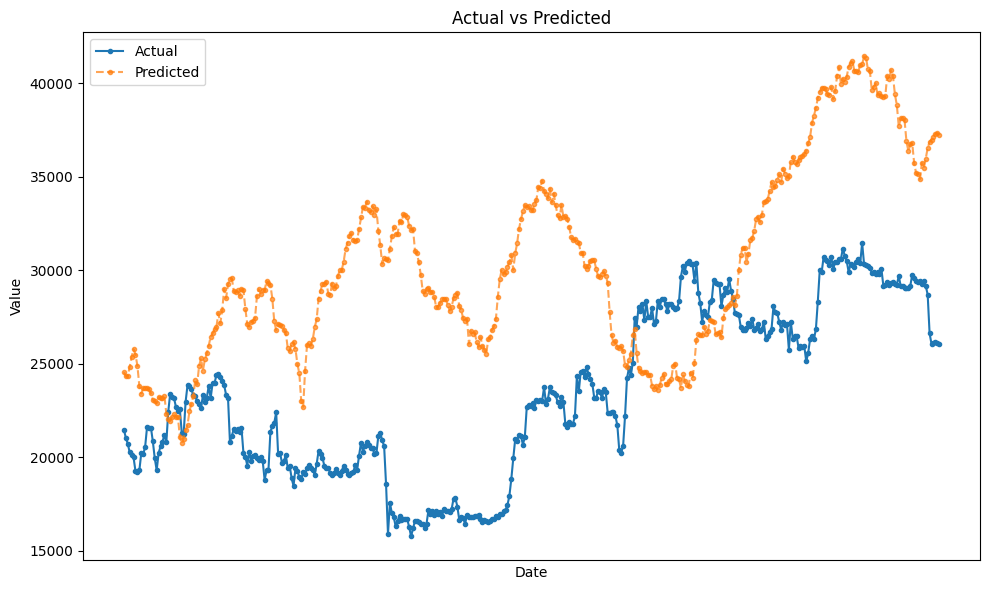

In [10]:
import matplotlib.pyplot as plt
import os

# Align the test dates with the predictions
test_dates_aligned = X_test['datetime'].values[-len(y_pred):]

# Ensure the directory exists
output_dir = 'figures/notebook06'
os.makedirs(output_dir, exist_ok=True)

# Visualization with actual datetime on the x-axis
plt.figure(figsize=(10, 6))
plt.plot(test_dates_aligned, y_test_original, label='Actual', marker='.', linestyle='-')
plt.plot(test_dates_aligned, y_pred, label='Predicted', alpha=0.7, marker='.', linestyle='--')
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated date labels

# Save the plot
plot_path = os.path.join(output_dir, 'actual_vs_predicted.png')
plt.savefig(plot_path, bbox_inches='tight')

# Show the plot
plt.show()


In [11]:
import pandas as pd
import os

# Create the directory if it doesn't exist
output_dir = 'tables/notebook06'
os.makedirs(output_dir, exist_ok=True)

# Define the paths for the LaTeX and CSV files
latex_path = os.path.join(output_dir, 'results.tex')
csv_path = os.path.join(output_dir, 'results.csv')

# Export the DataFrame to a LaTeX file
results_df.to_latex(latex_path, index=False)

# Export the DataFrame to a CSV file
results_df.to_csv(csv_path, index=False)

print(f"Results DataFrame has been exported to {latex_path} and {csv_path}")


Results DataFrame has been exported to tables/notebook06/results.tex and tables/notebook06/results.csv
